# Ray et al 2013 Intepretation
**Authorship:**
Adam Klie (last updated: *06/09/2023*)
***
**Description:**
Notebook to interpret the trained models on the Ray et al (2013) dataset.
***

In [51]:
# General imports
import os
import sys
import glob
import torch
import numpy as np
import pandas as pd

# EUGENe imports and settings
import eugene as eu
from eugene import preprocess as pp
from eugene import models, interpret
from eugene.models import zoo
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/ray13"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/ray13"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/ray13"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures//revision/ray13"

# EUGENe packages
import seqdata as sd
import motifdata as md
import seqpro as sp
from seqexplainer import evolution, attribute

# Other imports
import logomaker as lm

# For illustrator editing
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqData version: {sd.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Pandas version: 1.5.2
Eugene version: 0.0.8
SeqData version: 0.0.1


# Load the test `SeqData`

In [3]:
# Load the test data
sdata_test = sd.open_zarr(os.path.join(settings.dataset_dir, "norm_setB_ST.zarr"))
keys = pd.Index(sdata_test.data_vars.keys())
target_mask = keys.str.contains("RNCMPT")
target_cols = keys[target_mask]
sdata_test

<xarray.Dataset>
Dimensions:      (_sequence: 121031, _ohe: 4, length: 41)
Dimensions without coordinates: _sequence, _ohe, length
Data variables: (12/248)
    Probe_ID     (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    Probe_Set    (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    RNA_Seq      (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00001  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00002  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00003  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    ...           ...
    RNCMPT00285  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00287  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00288  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00289  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00291  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    ohe_seq      (_sequence, _ohe, length) float16 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>

In [4]:
# Get the MT training labels
sdata_training = sd.open_zarr(os.path.join(settings.dataset_dir, "norm_setA_sub_MT.zarr"))
keys_MT = pd.Index(sdata_training.data_vars.keys())
target_mask_MT = keys_MT.str.contains("RNCMPT")
target_cols_MT = keys_MT[target_mask_MT]
del sdata_training
len(target_cols_MT)

233

In [5]:
# Check the targets to make sure they are 244 and 233
len(target_cols), len(target_cols_MT)

(244, 233)

In [6]:
# Load in top 10 single task and multitask models
top_ST_tasks = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/ray13/performance/top_10_ST_intensities.tsv", sep="\t", index_col=0)
top_MT_tasks = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/ray13/performance/top_10_MT_intensities.tsv", sep="\t", index_col=0)

In [7]:
# Get the shared index
shared_top_10 = sorted(top_ST_tasks.index.intersection(top_MT_tasks.index))
shared_top_10

['RNCMPT00023',
 'RNCMPT00205',
 'RNCMPT00215',
 'RNCMPT00238',
 'RNCMPT00246',
 'RNCMPT00268',
 'RNCMPT00269']

In [12]:
# Get the indeces of the shared cols in the MT target cols
shared_top_10_MT_idx = np.where(target_cols_MT.isin(shared_top_10))[0]
shared_top_10_MT_idx

array([ 19, 172, 176, 194, 199, 215, 216])

In [13]:
# Define the arch for the single task model
arch_ST = models.zoo.DeepBind(
    input_len=41, # Length of padded sequences
    output_dim=1, # Number of multitask outputs
    conv_kwargs=dict(input_channels=4, conv_channels=[16], conv_kernels=[16], dropout_rates=0.5, batchnorm=True),
    dense_kwargs=dict(hidden_dims=[32], dropout_rates=0.5, batchnorm=True),
)

In [14]:
# Define the arch for the multitask model
version = 0
arch_MT = models.zoo.DeepBind(
    input_len=41, # Length of padded sequences
    output_dim=len(target_cols_MT), # Number of multitask outputs
    conv_kwargs=dict(input_channels=4, conv_channels=[1024], conv_kernels=[16], dropout_rates=0.25, batchnorm=0.25),
    dense_kwargs=dict(hidden_dims=[512], dropout_rates=0.25, batchnorm=True),
)

# Feature Attribution

## Single task models

In [15]:
# Get per nuceotide feature attibutions for each of the shared top 10 RBP prediction tasks
for i, target_col in enumerate(shared_top_10):
    print(f"Intepreting DeepBind SingleTask model on {target_col}")
    model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_ST", target_col, "checkpoints", "*"))[0]
    model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_ST)
    interpret.attribute_sdata(
        model,
        sdata_test,
        method="InputXGradient",
        suffix=f"_{target_col}_ST",
        batch_size=512,
        transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)}
    )

Intepreting DeepBind SingleTask model on RNCMPT00023


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting DeepBind SingleTask model on RNCMPT00205


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting DeepBind SingleTask model on RNCMPT00215


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting DeepBind SingleTask model on RNCMPT00238


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting DeepBind SingleTask model on RNCMPT00246


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting DeepBind SingleTask model on RNCMPT00268


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting DeepBind SingleTask model on RNCMPT00269


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

## Multi-task

In [16]:
# Load the multitask model
model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_MT", f"v{version}", "checkpoints", "*"))[0]
model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_MT)

In [17]:
# Get per nuceotide feature attibutions for each of the shared top 10 RBP prediction tasks
for i, target_col in zip(shared_top_10_MT_idx, shared_top_10):
    print(f"Intepreting version{version} DeepBind MultiTask model on {target_col}, which is the {i}th index of prediction")
    interpret.attribute_sdata(
        model,
        sdata_test,
        method="InputXGradient",
        target=int(i),
        suffix=f"_{target_col}_MT",
        batch_size=512,
        transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)}
    )

Intepreting version0 DeepBind MultiTask model on RNCMPT00023, which is the 19th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00205, which is the 172th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00215, which is the 176th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00238, which is the 194th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00246, which is the 199th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00268, which is the 215th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00269, which is the 216th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

## Plot feature attributions 

In [21]:
sdata_test = sdata_test.set_index(_sequence="Probe_ID")
for i, target_col in enumerate(shared_top_10):
    print(f"Plotting feature attribution scores for DeepBind models on {target_col}")
    top5_index = sdata_test[target_col].to_series().sort_values(ascending=False).index[:5]
    pl.multiseq_track(
        sdata_test,
        seq_ids=top5_index,
        attrs_keys=[f"InputXGradient_attrs_{target_col}_ST", f"InputXGradient_attrs_{target_col}_MT"],
        id_key="_sequence",
        vocab="RNA",
        width=30,
        height=6,
        ylabs=["InputXGradient SingleTask", "InputXGradient MultiTask"],
        save=os.path.join(eu.settings.figure_dir, "feature_attr", f"model_top5_feature_attr_{target_col}_STandMT.pdf")
    )
    plt.close()

Plotting feature attribution scores for DeepBind models on RNCMPT00023


Importance values:   0%|          | 0/2 [00:00<?, ?it/s]

Plotting feature attribution scores for DeepBind models on RNCMPT00205


Importance values:   0%|          | 0/2 [00:00<?, ?it/s]

Plotting feature attribution scores for DeepBind models on RNCMPT00215


Importance values:   0%|          | 0/2 [00:00<?, ?it/s]

Plotting feature attribution scores for DeepBind models on RNCMPT00238


Importance values:   0%|          | 0/2 [00:00<?, ?it/s]

Plotting feature attribution scores for DeepBind models on RNCMPT00246


Importance values:   0%|          | 0/2 [00:00<?, ?it/s]

Plotting feature attribution scores for DeepBind models on RNCMPT00268


Importance values:   0%|          | 0/2 [00:00<?, ?it/s]

Plotting feature attribution scores for DeepBind models on RNCMPT00269


Importance values:   0%|          | 0/2 [00:00<?, ?it/s]

# Filter viz

In [23]:
# Select the layer you want to interpret
layer_name = "arch.conv1d_tower.layers.1"

## Single task 

In [28]:
# Grab the pfms for the 16 filters of each single task model
for i, target_col in enumerate(shared_top_10):
    print(f"Generating pfms for single task DeepBind models on {target_col}")
    model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_ST", target_col, "checkpoints", "*"))[0]
    model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_ST)
    interpret.generate_pfms_sdata(
        model=model, 
        sdata=sdata_test,
        seq_key="ohe_seq",
        layer_name=layer_name,
        activation_threshold=0.75, 
        batch_size=2048,
        kernel_size=16,
        transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
        suffix=f"{target_col}_ST"
    )

Generating pfms for single task DeepBind models on RNCMPT00023


Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Generating pfms for single task DeepBind models on RNCMPT00205


Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Generating pfms for single task DeepBind models on RNCMPT00215


Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Generating pfms for single task DeepBind models on RNCMPT00238


Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Generating pfms for single task DeepBind models on RNCMPT00246


Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Generating pfms for single task DeepBind models on RNCMPT00268


Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Generating pfms for single task DeepBind models on RNCMPT00269


Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

## Multitask

In [36]:
# Load the multitask model
model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_MT", f"v{version}", "checkpoints", "*"))[0]
model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_MT)

In [37]:
# Grab the pfms for all filters of the multitask model, this requires a lot of mem!
interpret.generate_pfms_sdata(
    model=model, 
    sdata=sdata_test,
    seq_key="ohe_seq",
    layer_name=layer_name,
    activation_threshold=0.75, 
    kernel_size=16,
    batch_size=2048,
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    suffix=f"_MT"
)

Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Using all 1024 filters.


Getting filter activators for 1024 filters:   0%|          | 0/1024 [00:00<?, ?it/s]

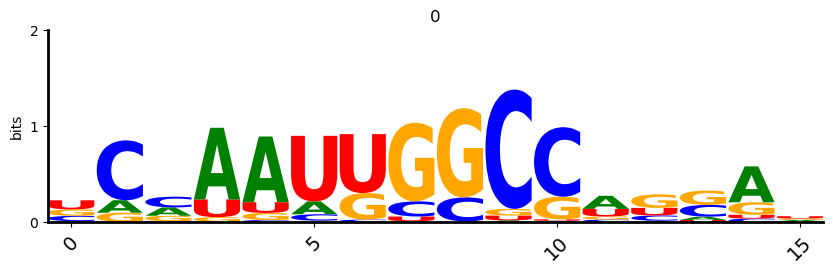

In [38]:
# Visualize a filter of choice
pl.filter_viz(
    sdata_test,
    filter_num=0,
    pfms_key=f"{layer_name}_pfms",
    vocab="RNA"
)

# Plot filter viz

In [46]:
# Visualizations for all 16 filters for DeepBind SingleTask models
for i, target_col in enumerate(shared_top_10):
    print(f"Plotting and saving filter visualizations for DeepBind models on {target_col}")
    pl.multifilter_viz(
        sdata_test,
        filter_nums=range(0,16),
        pfms_key=f"arch.conv1d_tower.layers.1_pfms{target_col}_ST",
        titles=[f"filter {i}" for i in range(16)],
        vocab="RNA",
        num_rows=4,
        num_cols=4,
        save=os.path.join(settings.figure_dir, "filter_viz", f"filters_viz_{target_col}_0.75_ST.pdf")
    )
    # Save all the filter pfms from above as meme format for submission to TomTom
    interpret.filters_to_meme_sdata(
        sdata_test,
        filters_key=f"arch.conv1d_tower.layers.1_pfms{target_col}_ST", 
        alphabet="ACGU",
        bg={"A": 0.25, "C": 0.25, "G": 0.25, "U": 0.25},
        axis_order=("_arch.conv1d_tower.layers.1_None_filters", "_ohe", "_arch.conv1d_tower.layers.1_16"),
        output_dir=os.path.join(settings.output_dir),
        filename=f"{target_col}_filters_0.75_ST.meme"
    )
    plt.close()

Plotting and saving filter visualizations for DeepBind models on RNCMPT00023
Output directory already exists: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13
Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13/RNCMPT00023_filters_0.75_ST.meme
Plotting and saving filter visualizations for DeepBind models on RNCMPT00205
Output directory already exists: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13
Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13/RNCMPT00205_filters_0.75_ST.meme
Plotting and saving filter visualizations for DeepBind models on RNCMPT00215
Output directory already exists: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13
Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13/RNCMPT00215_filters_0.75_ST.meme
Plotting and saving filter visualizations for 

In [50]:
# Visualizations for all filters of the multitask model
for i in range(32):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    pl.multifilter_viz(
        sdata_test,
        filter_nums=range(start_filter, end_filter),
        pfms_key=f"{layer_name}_pfms",
        vocab="RNA",
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        save=os.path.join(settings.figure_dir, "filter_viz", f"filters{start_filter+1}-{end_filter}_viz_MT.pdf")
    )
    plt.tight_layout()
    plt.close()

Plotting and saving filters 1-32
Plotting and saving filters 33-64
Plotting and saving filters 65-96
Plotting and saving filters 97-128
Plotting and saving filters 129-160
Plotting and saving filters 161-192
Plotting and saving filters 193-224
Plotting and saving filters 225-256
Plotting and saving filters 257-288
Plotting and saving filters 289-320
Plotting and saving filters 321-352
Plotting and saving filters 353-384
Plotting and saving filters 385-416
Plotting and saving filters 417-448
Plotting and saving filters 449-480
Plotting and saving filters 481-512
Plotting and saving filters 513-544
Plotting and saving filters 545-576
Plotting and saving filters 577-608
Plotting and saving filters 609-640
Plotting and saving filters 641-672
Plotting and saving filters 673-704
Plotting and saving filters 705-736
Plotting and saving filters 737-768
Plotting and saving filters 769-800
Plotting and saving filters 801-832
Plotting and saving filters 833-864
Plotting and saving filters 865-896


In [54]:
# Save all the filter pfms from above as meme format for submission to TomTom
interpret.filters_to_meme_sdata(
    sdata_test,
    filters_key=f"arch.conv1d_tower.layers.1_pfms", 
    alphabet="ACGU",
    bg={"A": 0.25, "C": 0.25, "G": 0.25, "U": 0.25},
    axis_order=("_arch.conv1d_tower.layers.1_1024_filters", "_ohe", "_arch.conv1d_tower.layers.1_16_kernel_size"),
    output_dir=os.path.join(settings.output_dir),
    filename=f"filters_0.75_MT.meme"
)

Output directory already exists: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13
Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13/filters_0.75_MT.meme


# *in silico*

In [91]:
# Load the ST model for an RBP of interest
rbp = shared_top_10[6]
model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_ST", rbp, "checkpoints", "*"))[0]
model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_ST)

In [87]:
# Evolve a set of 10 random sequences across 5 rounds
random_seqs = sp.ohe(sp.random_seqs(10, 41), alphabet=sp.ALPHABETS["RNA"]).transpose(0, 2, 1)
X_random = torch.tensor(random_seqs, dtype=torch.float32)
evolved_seqs = []
mutation_pos = []
for random_seq in random_seqs:
    evolved_res = evolution(
        model=model,
        X=random_seq,
        rounds=5,
    )
    evolved_seqs.append(evolved_res[0])
    mutation_pos.append(evolved_res[2])
X_evolved = torch.tensor(np.array(evolved_seqs), dtype=torch.float32)
mutation_pos = np.array(mutation_pos)

In [88]:
# Get the scores and the feature attributions for both the original random and the evolved
random_scores = model.predict(X_random)
random_explains = attribute(
    model=model,
    inputs=X_random,
    method="InputXGradient",
)
evolved_scores = model.predict(X_evolved)
evolved_explains = attribute(
    model=model,
    inputs=X_evolved,
    method="InputXGradient",
)

Predicting on batches: 0it [00:00, ?it/s]

Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting on batches: 0it [00:00, ?it/s]

Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

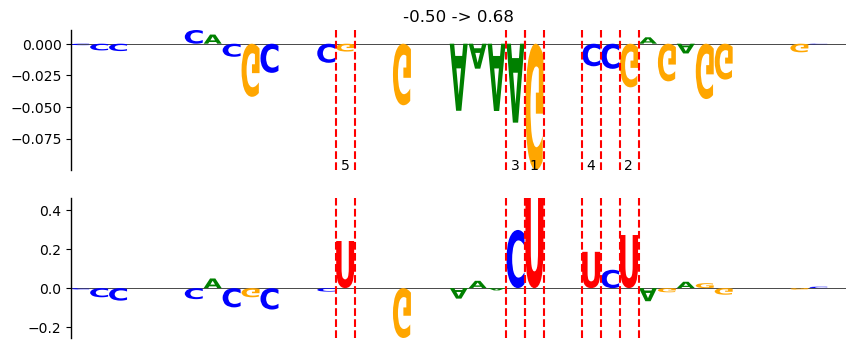

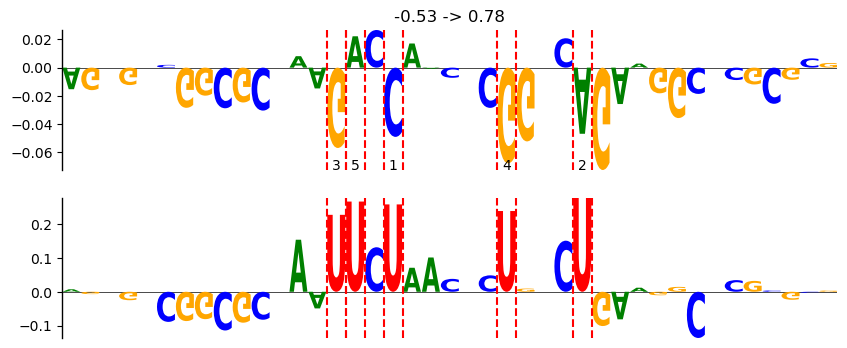

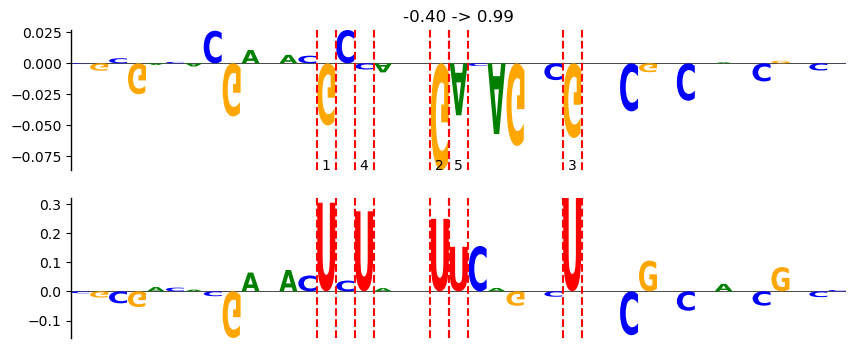

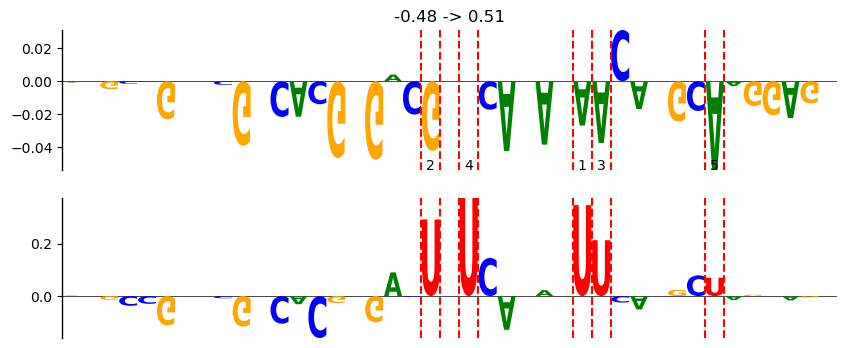

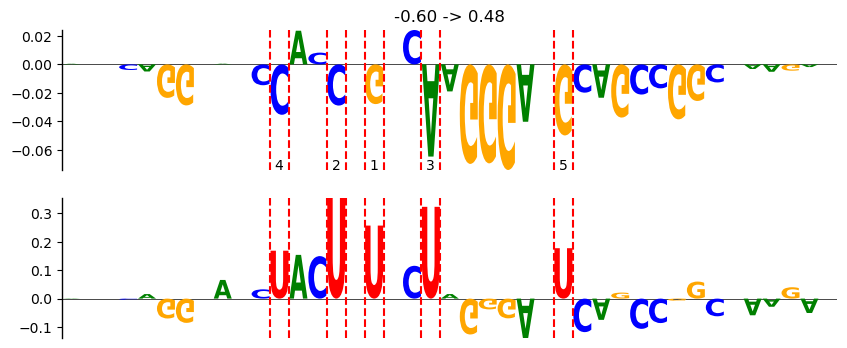

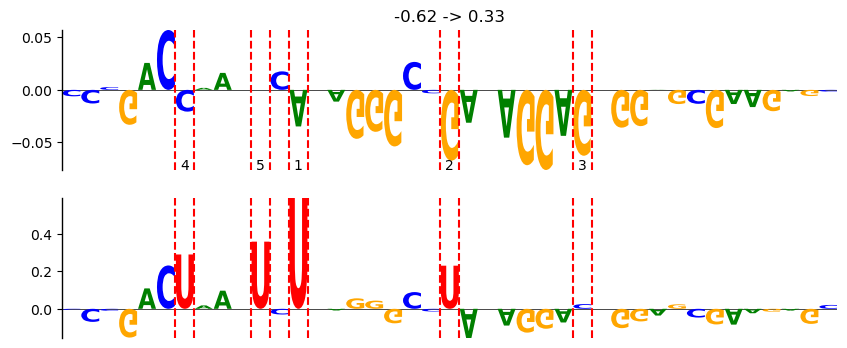

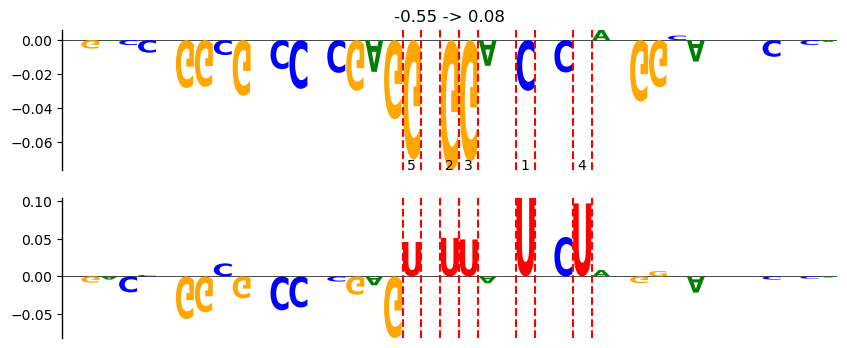

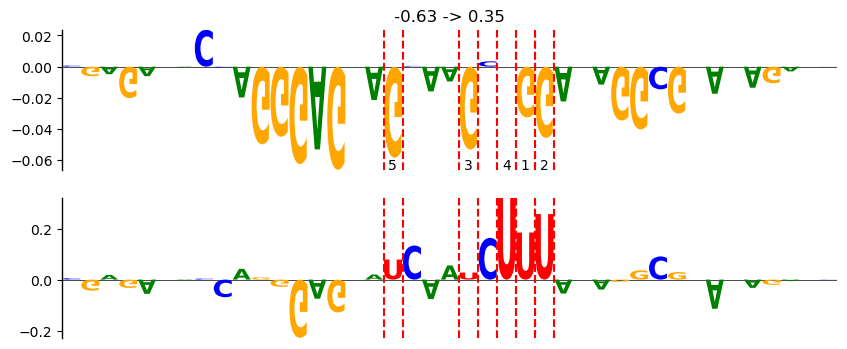

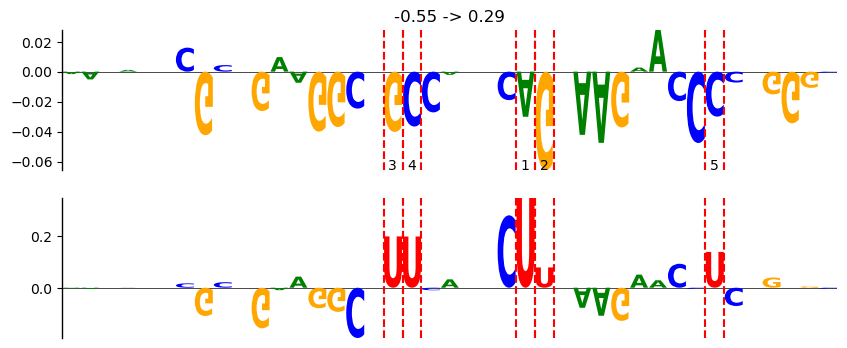

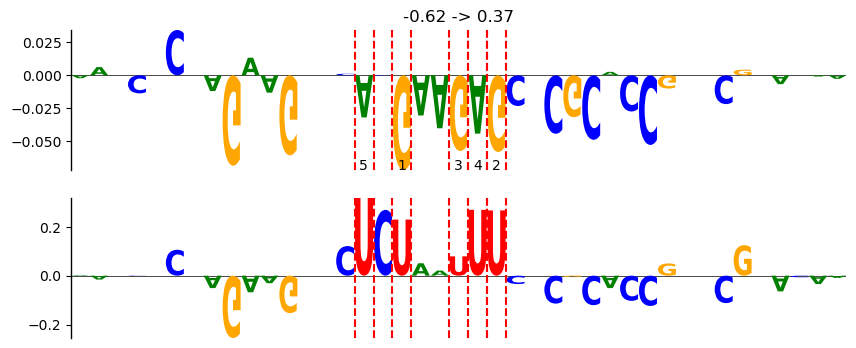

In [89]:
# Complicated plotting that we will eventually turn into a built in function
for i in range(len(random_explains)):
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    random_viz_seq = pd.DataFrame(random_explains[i].T, columns=["A", "C", "G", "U"])
    random_viz_seq.index.name = "pos"
    random_logo = lm.Logo(random_viz_seq, color_scheme="classic", figsize=(10, 2), ax=ax[0])
    random_logo.style_spines(visible=False)
    random_logo.style_spines(spines=['left'], visible=True)
    random_logo.ax.set_xticks([])
    ax[0].vlines(mutation_pos[i]-0.5, 0, 1, transform=ax[0].get_xaxis_transform(), colors='r', linestyle='--')
    ax[0].vlines(mutation_pos[i]+0.5, 0, 1, transform=ax[0].get_xaxis_transform(), colors='r', linestyle='--')
    ax[0].set_title(f"{random_scores[i].item():.2f} -> {evolved_scores[i].item():.2f}")
    ax_bottom = ax[0].get_ylim()[0]
    for j in range(len(mutation_pos[i])):
        ax[0].annotate(f"{j+1}", xy=(mutation_pos[i][j]-0.25, ax_bottom))
    evolved_viz_seq = pd.DataFrame(evolved_explains[i].T, columns=["A", "C", "G", "U"])
    evolved_viz_seq.index.name = "pos"
    evolved_logo = lm.Logo(evolved_viz_seq, color_scheme="classic", figsize=(10, 2), ax=ax[1])
    evolved_logo.style_spines(visible=False)
    evolved_logo.style_spines(spines=['left'], visible=True)
    evolved_logo.ax.set_xticks([])
    ax[1].vlines(mutation_pos[i]-0.5, 0, 1, transform=ax[1].get_xaxis_transform(), colors='r', linestyle='--')
    ax[1].vlines(mutation_pos[i]+0.5, 0, 1, transform=ax[1].get_xaxis_transform(), colors='r', linestyle='--')
    plt.savefig(os.path.join(settings.figure_dir, "ise", f"randseq{i}_evolution_{rbp}.pdf"))

# Save

In [104]:
# Save the SeqData with predictions and interpretations
sd.to_zarr(sdata_test, os.path.join(settings.output_dir, "norm_test_predictions_and_intepretations_0.75.zarr"), load_first=True, mode="w")

# DONE!

---

# Scratch

In [107]:
# Save the SeqData with predictions and interpretations
sdata = sd.open_zarr(os.path.join(settings.output_dir, "norm_test_predictions_and_intepretations_0.75.zarr"))

In [112]:
sdata.sd.uns

KeyError: 'sequence_dim'